In [1]:
from datetime import date
import yfinance as yf
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv",parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.head()
df

,date,price,wallets,address,mined
0,2010-09-25,0.1,2,656.0,4109450.00
1,2010-09-26,0.1,2,444.0,4110750.00
2,2010-09-27,0.1,2,1070.0,4132150.00
3,2010-09-28,0.1,2,1503.0,4133200.00
4,2010-09-29,0.1,2,1049.0,4148050.00
...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25


In [2]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years = 0
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

00:37:35 - cmdstanpy - INFO - Chain [1] start processing
00:37:36 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4381,2022-10-21,44874.712716,34785.125307,54113.404969
4382,2022-10-22,45071.105186,35285.180598,54714.096513
4383,2022-10-23,45244.704879,35726.904669,54454.990778
4384,2022-10-24,45449.054282,36328.190291,55454.219096
4385,2022-10-25,45612.718012,36192.621803,55036.165573


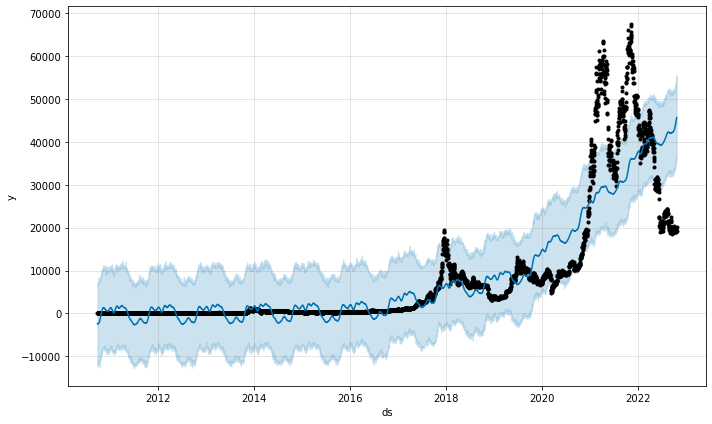

In [4]:
fig1 = m.plot(forecast)

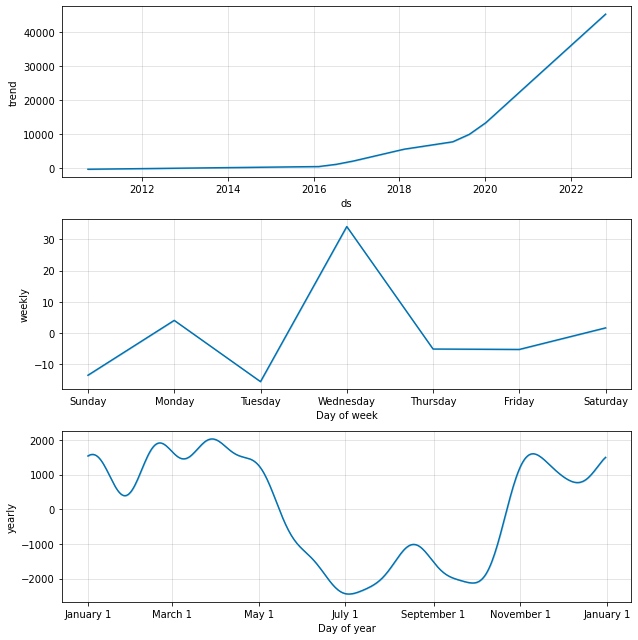

In [5]:
fig2 = m.plot_components(forecast)

In [6]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

00:37:38 - cmdstanpy - INFO - Chain [1] start processing
00:37:38 - cmdstanpy - INFO - Chain [1] done processing
00:37:39 - cmdstanpy - INFO - Chain [1] start processing
00:37:39 - cmdstanpy - INFO - Chain [1] done processing


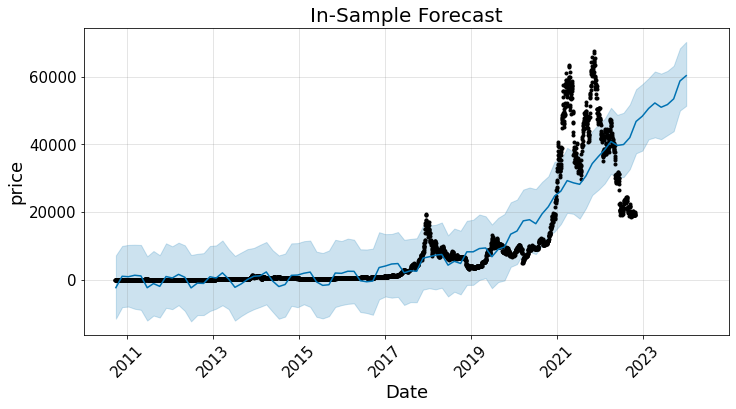

In [7]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-10-01", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("In-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("price", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-01-01', '2024-12-31'])) 
plt.show();

In [8]:
# SMAPE function
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ 
                     (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# Create a data frame of prediction and actual values
evaluation = pd.merge(
    # Prediction
    prediction[["ds", "yhat"]], 
    # Actual
    df_train[["ds", "y"]], 
    # Inner join on date
    how='inner', on='ds')

# MAPE and SMAPE
smape_kun(evaluation['y'],evaluation['yhat'])

MAPE: 2393057.98 % 
SMAPE: 200.00 %


In [9]:
import plotly.express as px

fig = px.line(x=df_train['ds'], y=df_train['y'])
fig.add_scatter(x=prediction['ds'], y=prediction['yhat'], name="Upper")
fig.add_scatter(x=prediction['ds'], y=prediction['yhat_lower'], name="Lower")
# fig.add_scatter(x=data.index, y=data['Open'], name="Open")

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

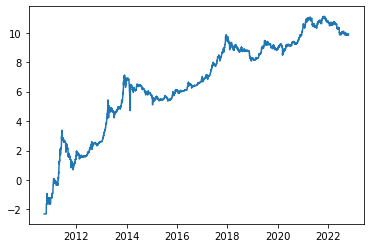

In [10]:
plt.plot(df['date'], np.log(df['price']))

In [11]:
from scipy.optimize import curve_fit
# Logarithmic function to fit against
def logFunc(x, p1, p2):
    return p1*np.log(x) + p2

ydata = np.log(df['price'])
xdata = [x+1 for x in range(len(df))]
popt, pcov = curve_fit(logFunc, xdata, ydata, p0=(3.0,-10))

print(popt)
print(pcov)

[  3.01978989 -15.7389369 ]
[[ 0.00031409 -0.00232032]
 [-0.00232032  0.01745208]]


In [12]:
fittedYdata = logFunc(np.array([x+1 for x in range(len(df))]), popt[0], popt[1])
fittedYdata

array([-15.7389369 , -13.64577805, -12.42135862, ...,   9.58416601,
         9.58485475,   9.58554334])

Text(0, 0.5, 'price')

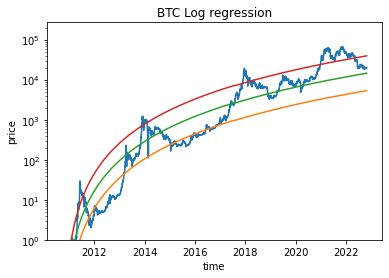

In [13]:
plt.semilogy(df['date'], df['price'])
for i in range(-1, 2):
    plt.plot(df['date'], np.exp(fittedYdata+i))
plt.ylim(bottom=1)

plt.title('BTC Log regression')

plt.xlabel('time')
plt.ylabel('price')

In [14]:
## Wallets

In [15]:
df_trainw = df[['date', 'address']]
df_trainw = df_trainw.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_trainw)

n_years = 3
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecastw = m.predict(future)

00:37:43 - cmdstanpy - INFO - Chain [1] start processing
00:37:45 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecastw[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5476,2025-10-20,907386.780343,252563.495228,1.529671e+06
5477,2025-10-21,920086.917031,290083.107172,1.560791e+06
5478,2025-10-22,916872.212325,265782.801242,1.556999e+06
5479,2025-10-23,915624.359527,279075.914161,1.517840e+06
5480,2025-10-24,917193.703548,256718.591043,1.551601e+06


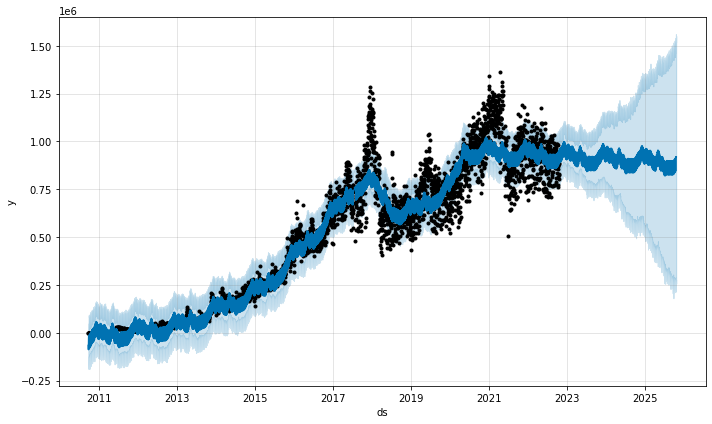

In [17]:
fig1 = m.plot(forecastw)

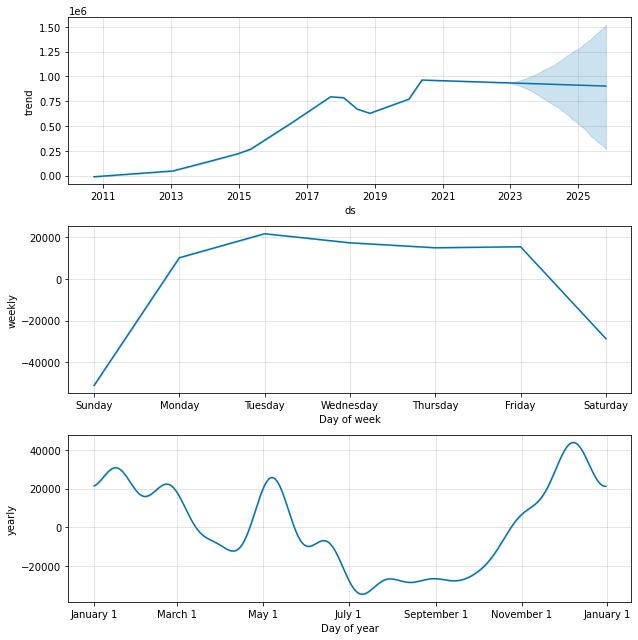

In [18]:
fig2 = m.plot_components(forecastw)

In [19]:
df_trainw = df[['date', 'address']]
df_trainw = df_trainw.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_trainw)

# instantiate the model and set parameters
modelw = Prophet()

# fit the model to historical data
modelw.fit(df_trainw);

00:37:47 - cmdstanpy - INFO - Chain [1] start processing
00:37:49 - cmdstanpy - INFO - Chain [1] done processing
00:37:50 - cmdstanpy - INFO - Chain [1] start processing
00:37:51 - cmdstanpy - INFO - Chain [1] done processing


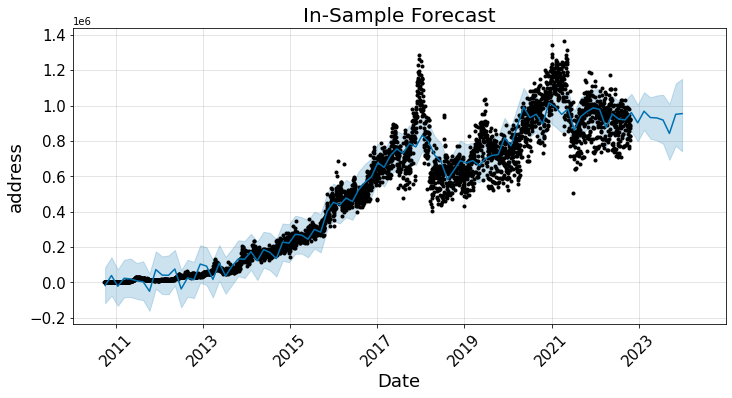

In [20]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-10-01", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
predictionw = modelw.predict(insample)

# Plot
fig = modelw.plot(predictionw, figsize=(10,5))
ax = fig.gca()
ax.set_title("In-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("address", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-01-01', '2024-12-31'])) 
plt.show();

In [21]:
# SMAPE function
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ 
                     (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# Create a data frame of prediction and actual values
evaluationw = pd.merge(
    # Prediction
    predictionw[["ds", "yhat"]], 
    # Actual
    df_trainw[["ds", "y"]], 
    # Inner join on date
    how='inner', on='ds')

# MAPE and SMAPE
smape_kun(evaluationw['y'],evaluationw['yhat'])

MAPE: 2750.03 % 
SMAPE: 200.00 %


In [22]:
import plotly.express as px

fig = px.line(x=df_trainw['ds'], y=df_trainw['y'])
fig.add_scatter(x=predictionw['ds'], y=predictionw['yhat'], name="Upper")
fig.add_scatter(x=predictionw['ds'], y=predictionw['yhat_lower'], name="Lower")
# fig.add_scatter(x=data.index, y=data['Open'], name="Open")

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()
fig.write_html('trial.html')


In [23]:
import plotly.express as px

fig = px.line(x=df_trainw['ds'], y=df_trainw['y'])
fig.add_scatter(x=predictionw['ds'], y=predictionw['yhat'], name="Upper")
fig.add_scatter(x=predictionw['ds'], y=predictionw['yhat_lower'], name="Lower")
fig.add_scatter(x=prediction['ds'], y=prediction['yhat'], name="Upper")


fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

In [24]:
# import graph_objects from plotly package
import plotly.graph_objects as go

# import make_subplots function from plotly.subplots
# to make grid of plots
from plotly.subplots import make_subplots

# use specs parameter in make_subplots function
# to create secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# plot a bar chart by specifying the x and y values
# Use add_trace function to specify secondary_y axes.
fig.add_trace(
	go.Scatter(x=prediction['ds'], y=prediction['yhat_lower'], name="address Upper Prediction"),
	secondary_y=False)

# Use add_trace function and specify secondary_y axes = True.
fig.add_trace(
	go.Scatter(x=prediction['ds'], y=prediction['yhat'], name="Price Upper Prediction"),
	secondary_y=True,)

fig.add_trace(
	go.Scatter(x=df_train['ds'], y=df_train['y'], name="Price Actual"),
	secondary_y=True,)

# Adding title text to the figure
fig.update_layout(
    # split the x-axis to fraction of plots in
    # proportions
    xaxis=dict(
        domain=[0.3, 0.7]
    ),
   
    # pass the y-axis title, titlefont, color
    # and tickfont as a dictionary and store
    # it an variable yaxis
    yaxis=dict(
        title="Wallets Upper Prediction",
        titlefont=dict(
            color="#0000ff"
        ),
        tickfont=dict(
            color="#0000ff"
        )
    ),
     
    # pass the y-axis 2 title, titlefont, color and
    # tickfont as a dictionary and store it an
    # variable yaxis 2
    yaxis2=dict(
        title="Price Upper Prediction",
        titlefont=dict(
            color="#0000ff"
        ),
        tickfont=dict(
            color="#0000ff"
        ),
        anchor="free",  # specifying x - axis has to be the fixed
        overlaying="y",  # specifyinfg y - axis has to be separated
        side="left",  # specifying the side the axis should be present
        position=0.2  # specifying the position of the axis
    ),
   
    # pass the y-axis 3 title, titlefont, color and
    # tickfont as a dictionary and store it an
    # variable yaxis 3
    yaxis3=dict(
        title="Price Actual",
        titlefont=dict(
            color="#0000ff"
        ),
        tickfont=dict(
            color="#0000ff"
        ),
        anchor="x",     # specifying x - axis has to be the fixed
        overlaying="y",  # specifyinfg y - axis has to be separated
        side="right"  # specifying the side the axis should be present
    ),
     

)

# Naming x-axis
fig.update_xaxes(title_text="X - axis")

# Naming y-axes
fig.update_yaxes(title_text="<b>Main</b> Y - axis ", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Y - axis ", secondary_y=True)
